In [53]:
# 1) quasi random numbers
# 2) importance sampling: sample from the region of the tail (look for extremes) that is most important, this will reduce variance 

BASELINE

In [1]:
import numpy as np, pandas as pd, scipy.stats as st

In [2]:
data = pd.read_csv('data.csv')
num_obvs = 100_000
# risks per sector
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
#sec_loading maps sector to its risk, t is the threshold for defaults
data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)
# 100k monte carlo simulations and len(r)+len(data) risk factors per one sample
factors, sample, vars = np.random.normal(0,1, (num_obvs, len(r)+len(data))), [], []

In [3]:
for obs in factors:
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]
    ind = r[0]**.5 * m_factor + (data.sec_loading-r[0])**.5 * sec_factor + (1-
                                                                            data.sec_loading)**.5 * res_factor < data.t
    loss = np.zeros((len(data),))
    loss[ind] = data[ind].m + data[ind].d * np.random.standard_t(3, size=sum(ind))
    sample.append(sum(loss))
    vars.append(np.var(loss))

In [4]:
# extracts the 1% quantile from the sorted list of 100k observations
VaR = sorted([-s for s in sample])[int(0.001*num_obvs)]

In [5]:
VaR

-18202.114253385902

In [6]:
variance = np.mean(vars)

In [7]:
variance

1339.4330685893594

In [8]:
losses = np.array(sample)
quantile_99_9 = np.percentile(losses, 0.001)
extreme_losses = losses[losses <= quantile_99_9]
np.median(extreme_losses)

-61573.83472764848

IMPORTANCE SELECTION

In [111]:
np.min(losses)

-45729.77151094579

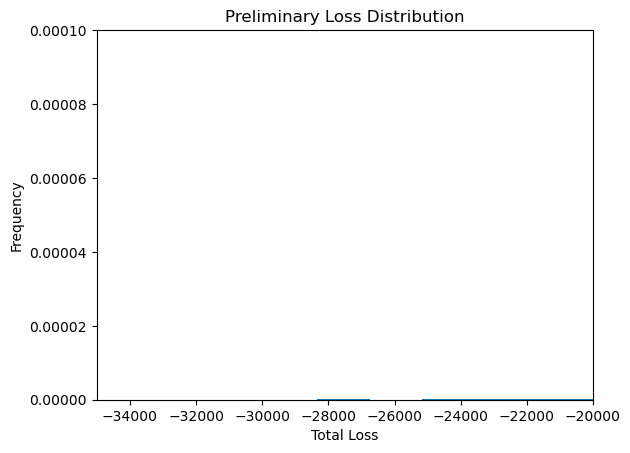

In [109]:
import matplotlib.pyplot as plt

plt.hist(sample, bins=50, density=True)
plt.title("Preliminary Loss Distribution")
plt.xlabel("Total Loss")
plt.ylabel("Frequency")
plt.xlim(-35000,-20000)
plt.ylim(0, 0.00010)
plt.show()

In [79]:
def target_pdf(x):
    return st.t.pdf(x, df=3)

def proposal_pdf(x, shift=-15000):
    return st.t.pdf(x - shift, df=3)

def generate_proposal_samples(size, shift=-10000):
    return st.t.rvs(df=3, loc=shift, size=size)

def importance_sampling_var(num_samples=100_000, shift=-10000):
    sample_losses = []
    weights = []

    proposal_samples = generate_proposal_samples(num_samples, shift)

    for obs in proposal_samples:
        w = target_pdf(obs) / proposal_pdf(obs, shift)

        m_factor = np.random.normal(0, 1)  # Global market factor
        sec_factor = np.random.normal(0, 1, len(r))  # Sector factors
        res_factor = obs  # Residual factor from the proposal distribution

        ind = (r[0]**0.5 * m_factor +
               (data.sec_loading - r[0])**0.5 * sec_factor[data['sector'].values] +
               (1 - data.sec_loading)**0.5 * res_factor) < data['t']

        loss = np.zeros(len(data))
        loss[ind] = data['m'][ind] + data['d'][ind] * res_factor

        # Weighted loss
        sample_losses.append(np.sum(loss) * w)
        weights.append(w)

    sorted_losses = np.array(sample_losses)[np.argsort(sample_losses)]
    sorted_weights = np.array(weights)[np.argsort(sample_losses)]
    cumulative_weights = np.cumsum(sorted_weights) / np.sum(sorted_weights)

    VaR_index = np.searchsorted(cumulative_weights, 0.999)
    VaR = sorted_losses[VaR_index]

    return VaR, sample_losses

In [80]:
Var2, losses2 = importance_sampling_var()

In [82]:
losses2

[-1.3066700551051613e-06,
 -0.0011614645240684922,
 -1.9511910646515727e-06,
 -2.060797362525313e-06,
 -3.5089458138194146e-06,
 -1.4001440110666749e-06,
 -1.6885039254195722e-06,
 -1.3141986797759197e-06,
 -6.0284585549505854e-06,
 -1.3190005651460325e-06,
 -2.3066619119217776e-06,
 -1.5204323957070825e-06,
 -9.180915759417668e-06,
 -9.965028997716893e-06,
 -1.3129980189504307e-06,
 -1.362281011347803e-06,
 -6.179988866020991e-06,
 -1.5124975981295102e-06,
 -1.4344469962204939e-06,
 -1.3708175353121611e-06,
 -1.5140699526760313e-06,
 -1.8705401401451607e-06,
 -4.972853213912716e-06,
 -7.430687419695678e-05,
 -3.888162997678699e-06,
 -2.147349672873468e-06,
 -1.3772618794542481e-06,
 -3.280209841009301e-06,
 -1.4239516342805527e-06,
 -2.187878085636181e-06,
 -1.6130357322114852e-05,
 -1.834531412735471e-06,
 -1.3809765962186621e-05,
 -3.2868555021694413e-06,
 -2.4335101624132084e-06,
 -1.309714911435178e-06,
 -1.5546253552237142e-05,
 -8.634429279780398e-06,
 -1.404575394408999e-06,
 -

VERSION 2 IMPORTANCE

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st

# Load data
data = pd.read_csv('data/data.csv')
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)

# Importance Sampling Parameters
shift = 2.0  # Shift parameter to bias the sampling distribution towards the tail

# Simulate factors and initialize
factors = np.random.normal(shift, 1, (100_000, len(r) + len(data)))  # Shifted Gaussian
sample, weights = [], []

for obs in factors:
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]

    # Adjusted loss indicator threshold
    ind = np.sqrt(r[0]) * m_factor + np.sqrt(data.sec_loading - r[0]) * sec_factor \
          + np.sqrt(1 - data.sec_loading) * res_factor < (data.t - shift)

    # Compute losses
    loss = np.zeros((len(data),))
    loss[ind] = data[ind].m + data[ind].d * np.random.standard_t(3, size=sum(ind))

    # Compute weight for importance sampling correction
    weight = np.exp(-shift * obs[0] + 0.5 * shift**2)
    weights.append(weight)
    sample.append(sum(loss) * weight)  # Adjusted loss weighted

# Calculate VaR using weighted losses
weighted_losses = -np.array(sample)
sorted_losses = np.sort(weighted_losses)
VaR = sorted_losses[int(0.999 * len(sorted_losses))]  # Empirical 99.9% quantile
print(f"VaR with Importance Sampling: {VaR}")

HEREZJA SOBOL

In [61]:
num_dimensions = len(r) + len(data)

In [62]:
from scipy.stats import qmc
sobol_sampler = qmc.Sobol(d=num_dimensions, scramble=True)
quasi_random_samples = sobol_sampler.random_base2(m=int(np.log2(num_obvs)))

In [63]:
factors = st.norm.ppf(quasi_random_samples)

In [64]:
from scipy.stats import t
sample = []
sobol_student= qmc.Sobol(d=1, scramble=True)
for obs in factors:
    # m_factor, sec_factor, res_factor = obs[0], obs[1:1 + len(r)][data.sector.values], obs[len(r):]
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]

    ind = (
                  r[0]**0.5 * m_factor
                  + (data.sec_loading - r[0])**0.5 * sec_factor
                  + (1 - data.sec_loading)**0.5 * res_factor
          ) < data.t
    loss = np.zeros((len(data),))
    stt=sobol_student.random(n=sum(ind)).flatten()
    stud = st.t.ppf(stt,3)
    loss[ind] = data[ind].m + data[ind].d * stud
    sample.append(sum(loss))

In [65]:
VaR = sorted([-s for s in sample])[int(0.01 * num_obvs)]

In [66]:
VaR

-5396.849243209308

PARALLEL

In [0]:
import numpy as np, pandas as pd, scipy.stats as st

data = pd.read_csv('data.csv')
num_obvs = 1000000

r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])

data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)

num_dimensions = len(r) + len(data)
from scipy.stats import qmc

sobol_sampler = qmc.Sobol(d=num_dimensions, scramble=True)
quasi_random_samples = sobol_sampler.random_base2(m=int(np.log2(num_obvs)))

factors = st.norm.ppf(quasi_random_samples)

def process_obs(obs):
    # m_factor, sec_factor, res_factor = obs[0], obs[1:1 + len(r)][data.sector.values], obs[len(r):]
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]

    ind = (
                  r[0] ** 0.5 * m_factor
                  + (data.sec_loading - r[0]) ** 0.5 * sec_factor
                  + (1 - data.sec_loading) ** 0.5 * res_factor
          ) < data.t
    loss = np.zeros((len(data),))
    stt = sobol_student.random(n=sum(ind)).flatten()
    stud = st.t.ppf(stt, 3)
    loss[ind] = data[ind].m + data[ind].d * stud
    return sum(loss)

In [66]:
from joblib import Parallel, delayed
from scipy.stats import t

sobol_student = qmc.Sobol(d=1, scramble=True)
sample_parallel = Parallel(n_jobs=-1)(delayed(process_obs)(obs) for obs in factors)
VaR = sorted([-s for s in sample_parallel])[int(0.01 * num_obvs)]

ANTITHETIC 

In [66]:
factors = np.random.normal(0, 1, (num_obvs // 2, len(r) + len(data)))
antithetic_factors = -factors

factors = np.vstack([factors, antithetic_factors])
sample_antithetic = []

for obs in factors:
    m_factor = obs[0] 
    sec_factor = obs[:len(r)][data.sector.values] 
    res_factor = obs[len(r):]  

    ind = (
                  r[0]**0.5 * m_factor
                  + (data.sec_loading - r[0])**0.5 * sec_factor
                  + (1 - data.sec_loading)**0.5 * res_factor
          ) < data.t
    loss = np.zeros((len(data),))
    loss[ind] = data[ind].m + data[ind].d * t.rvs(df=3,size=sum(ind))
    sample.append(sum(loss))
    
    sample_antithetic.append(sum(loss))
    
    Var_antithetic = sorted([-s for s in sample])[100]

In [68]:
Var_antithetic

-10697.589807499246